In [ ]:
#READING CSV
import pandas as pd
from copy import deepcopy
import math

almacenes = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/almacenes.csv")
alm = almacenes[['Coord X', 'Coord Y']]
nodeTypeALM = [1]*100
alm['NodeType'] = nodeTypeALM

puntos_entrega = pd.read_csv("https://raw.githubusercontent.com/billguerrerog/cc41_tf_201821590_20181B402_201811208_201823346_201823838/main/puntos_entrega.csv")
pe = puntos_entrega[['Coord X', 'Coord Y']]
nodeTypePE = [2]*5000
pe['NodeType'] = nodeTypePE

In [ ]:
#Join both lists
newDF = pd.concat([alm, pe])

#List to use (nodeType) and list to compare (noType)
nodeTypeList = newDF[['Coord X', 'Coord Y', 'NodeType']].values.tolist()
noTypeList = newDF[['Coord X', 'Coord Y']].values.tolist()

In [ ]:
#Sorting List by Y then by X
def orderList(list_):
    newL = sorted(list_, key=lambda y: y[1])
    newL.sort(key=lambda x: x[0])
    return deepcopy(newL)

newL = orderList(noTypeList)
newTypeList = orderList(nodeTypeList)

In [ ]:
# Storage/DeliveryPoint Nodes to append
def popStuff(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        to_return.append(popList.pop())
    popList.reverse()
    return to_return

#Search X Coords Nodes (it's sorted already)
def searchX(tempList, tempNodeTypeList, x):
    returnList = []
    popped = []
    max = 0

    if len(tempList)==0 and len(tempNodeTypeList)==0:
        return returnList, popped
    for i in tempList: #Getting comparison list
        if i[0] == x:
            max += 1
            returnList.append(i)
        else:
            break
    
    popStuff(tempList, max)
    popped = []
    popped = popStuff(tempNodeTypeList, max)
    return returnList, popped

In [ ]:
# Create graph
def graph(nodesList, newL_, newTypeList_):
    xList = [i for i in range(1000)]
    yList = [i for i in range(1000)]
    nodesCont = 0

    tempNoTypeList = deepcopy(newL_)
    tempTypeList = deepcopy(newTypeList_)

    for x in xList:
        smallList = [] #Comparison list
        popped = [] #To List
        if len(tempNoTypeList)>0 and len(tempTypeList)>0:
            smallList, popped = searchX(tempNoTypeList, tempTypeList, x)
        for y in yList:
            ady1 = nodesCont - 1000 #left then goes clockwise
            ady2 = nodesCont - 1
            ady3 = nodesCont + 1000
            ady4 = nodesCont + 1
            # Validations - not corners
            if x == 0: ady1 = -1
            if x == 999: ady3 = -1
            if y == 0: ady2 = -1
            if y == 999: ady4 = -1

            ady0 = [ady1, ady2, ady3, ady4]

            if len(popped) > 0 and len(smallList) > 0 and [x, y] in smallList:
                t = popped.pop(0)
                nodesList.append([t[0], t[1], t[2], ady0])
            else:
                nodesList.append([x, y, 0, ady0])
            
            nodesCont += 1

In [ ]:
# Creating the new graph
nodes = []
graph(nodes, newL, newTypeList)

In [ ]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [ ]:
#Methods to show graph
def popStuffAndDelete(popList, times):
    to_return = []
    popList.reverse()
    for j in range(times):
        popped = popList.pop()
        del popped[3]
        del popped[2]
        to_return.append(popped)
    popList.reverse()
    return to_return

def deleteStuff(nodesList):
    for i in nodesList:
        del i[3]
        del i[2]

def separateTypes(tempNodes, x):
    max = 0
    for i in tempNodes:
        if i[2] == x:
            max += 1
        else:
            popped = popStuffAndDelete(tempNodes, max)
            return popped

In [ ]:
#Copies to show graph
new_nodes = sorted(nodes_copy, key=lambda y: y[2])
new_nodes_copy = deepcopy(new_nodes)

normal_nodes = separateTypes(new_nodes_copy, 0)
alm_nodes = separateTypes(new_nodes_copy, 1)
ent_nodes = new_nodes_copy
deleteStuff(ent_nodes)

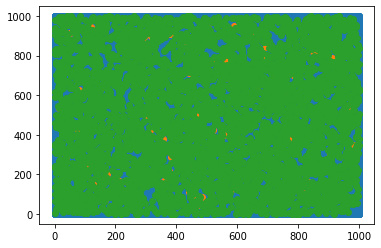

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Show graph
normal_np = np.array(normal_nodes)
alm_np = np.array(alm_nodes)
ent_np = np.array(ent_nodes)

plt.scatter(*zip(*normal_np))
plt.scatter(*zip(*alm_np))
plt.scatter(*zip(*ent_np))

cm = 1/2.54
plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
plt.rcParams["figure.autolayout"] = True
plt.show()

In [ ]:
# Making a copy of resulting graph
nodes_copy = deepcopy(nodes)

In [ ]:
# BFS since all edges have the same weight (from a node)
def bfs(graph, s, size):
    visited = [False]*size
    parent = [None]*size
    queue = [s]
    visited[s] = True

    while queue:
        u = queue.pop(0)
        node = graph[u]
        for v in node[3]:
            if v >= 0:
                if not visited[v]:
                    visited[v] = True
                    parent[v] = u
                    queue.append(v)

    return parent

def find_route(all_routes, alm_node, ent_node):
    start_node = all_routes[ent_node] #returns parent
    #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
    #Las rutas se obtienen recorriendo las rutas generales de manera inversa
    route = []
    route.append(ent_node)

    if start_node == alm_node: #Comprueba si son nodos adyacentes
        route.append(alm_node)
        route.reverse()
        return route

    while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
        route.append(start_node)
        start_node = all_routes[start_node]

    route.append(alm_node)
    route.reverse()
    return route #returns 1 route

def get_coords(i):
    z = 1000
    x = i//z
    y = i % z
    return x, y

def get_node(x, y):
    return (x*1000) + y

def get_distance(alm_node, ent_node):
    alm_x, alm_y = get_coords(alm_node)
    ent_x, ent_y = get_coords(ent_node)
    return math.sqrt((ent_x - alm_x)**2 + (ent_y - alm_y)**2)

def find_nodes(graph, node_type, max):
    nodes = []
    cont_ent = 0
    size = len(graph)
    for i in range(size):
        if graph[i][2] == node_type:
            nodes.append(i)
            cont_ent += 1
        if cont_ent == max:
            return nodes #returns all nodes of that type

In [ ]:
def find_shorter_route(graph, alm_node, size, ent_nodes_list, routes, shortest_routes):
    parent = bfs(graph, alm_node, size)

    for i in range(len(ent_nodes_list)): #ent_nodes
        route = []
        route.append(alm_node)
        route.append(ent_nodes_list[i])
        #check_route = find_route(parent, alm_node, ent_nodes_list[i])
        check_distance = get_distance(alm_node, ent_nodes_list[i]) #Closest to Storage Point
        if len(shortest_routes) < len(ent_nodes_list): # Empty list
            routes.append(route)
            shortest_routes.append(check_distance)
        else:
            #if len(check_route) < len(shortest_routes[i]): #Check if it's a shorter route
            if check_distance < shortest_routes[i]:
                routes[i] = route
                shortest_routes[i] = check_distance # Replace if so

def pop_asigned_delivery(ordered_list, storage_point):
    delivery_points = []
    for j in range(len(ordered_list)):
        if ordered_list[-1][0] == storage_point:
            aux = ordered_list.pop()
            delivery_points.append(aux[1])
            if len(ordered_list) == 0:
                return delivery_points
        else:
            return delivery_points

def shortest_routes(graph, size): #Only asking to every Storage node
    routes = []
    shortest_routes = []
    cont_alm = 0
    alm_nodes_list = find_nodes(graph, 1, 100) #alm = 1 / ent = 2
    ent_nodes_list = find_nodes(graph, 2, 5000) #alm = 1 / ent = 2

    for i in range(len(alm_nodes_list)):
        find_shorter_route(graph, alm_nodes_list[i], size, ent_nodes_list, routes, shortest_routes)

    #Order by Storage Point
    ordered_by_alm = sorted(routes, key=lambda a: a[0], reverse=True)
    by_alm = []
    for i in alm_nodes_list:
        asigned_delivery_points = []
        asigned_delivery_points = pop_asigned_delivery(ordered_by_alm, i)
        aux = []
        aux.append(i)
        aux.append(asigned_delivery_points)
        by_alm.append(aux)

    return by_alm #5k routes

In [ ]:
#Takes 3 mins
asigned_delivery_points = shortest_routes(nodes_copy, len(nodes_copy))

In [ ]:
for i in range(100):
    print(asigned_delivery_points[i])

[16535, [28485, 21503, 21469, 20478, 20476, 17545, 17468, 16471, 13534, 11475, 10544, 10485, 6498, 2590, 1461]]
[25978, [83998, 66974, 66963, 62987, 55999, 51975, 50955, 42956, 41999, 41988, 23993, 23974, 22962, 18987, 18974, 15996, 15969, 1978, 942]]
[29539, [30558, 25549, 23569, 20582, 20555, 15600, 14594, 4601]]
[31539, [124541, 124539, 112520, 109516, 108535, 104547, 104520, 103534, 95543, 94537, 93538, 81551, 81547, 81499, 80512, 79501, 74530, 74523, 74515, 72567, 70505, 69558, 64527, 60542, 59520, 58581, 55532, 54503, 52510, 51528, 48568, 45574, 45568, 45523, 42559, 40545, 38584, 38497, 36544, 35497, 33525]]
[38287, [91302, 91293, 83315, 82295, 78319, 78281, 76283, 71329, 69311, 62339, 57298, 57258, 54328, 51322, 47339, 42260, 37302, 37289, 34233, 31254, 29334, 28326, 28313, 23360, 21274, 21211, 19312, 18277, 17225, 16344, 16331, 16316, 16266, 15306, 10243, 8212, 4316, 4306, 4205, 3353, 3314, 1343, 1244, 1233]]
[50913, [75892, 70909, 69895, 69884, 61927, 61919, 61878, 51881, 4391

In [ ]:
#Get single region
def get_region(alm, asigned_delivery):
    min_x, min_y = get_coords(alm) # Start
    max_x, max_y = get_coords(alm) # Start
    for i in asigned_delivery: #Getting min and max coords to create region
        delivery_x, delivery_y = get_coords(i) #Coords to compare
        if delivery_x < min_x: #Check min X
            min_x = delivery_x
        elif delivery_x > max_x: #Check max X
            max_x = delivery_x
        if delivery_y < min_y: #Check min Y
            min_y = delivery_y
        elif delivery_y > max_y: #Check max Y
            max_y = delivery_y

    min_max = [min_x, min_y, max_x, max_y]
    return min_max

# Get Regions
def all_regions(asigned_stuff):
    regions = []
    for i in asigned_stuff:
        aux = []
        region = get_region(i[0], i[1])
        aux.append(i[0])
        aux.append(region) #Region coords
        regions.append(aux)
    
    return regions

In [ ]:
regions = all_regions(asigned_delivery_points)

In [ ]:
import heapq as hq

def adjacencies(region): #Create region adjacencies
    xList = [i for i in range(region[0], region[2] + 1)]
    yList = [i for i in range(region[1], region[3] + 1)]

    nodes_region = {}

    for x in xList:
        for y in yList:
            nodes_region[get_node(x, y)] = []
    
    for node in nodes_region:
            ady1 = node - 1000 #left then goes clockwise
            ady2 = node - 1
            ady3 = node + 1000
            ady4 = node + 1

            ady0 = [ady1, ady2, ady3, ady4]
            for i in ady0:
                if i in nodes_region:
                    nodes_region[node].append(i)
    
    return nodes_region

def new_dijkstra(graph, start):
    visited = {}
    parent = {}
    cost = {}
    queue = [(start, 0)]
    for i in graph.keys():
        visited[i] = False
        parent[i] = None
        cost[i] = math.inf
    
    cost[start] = 0

    while queue:
        u, g_u = hq.heappop(queue)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    hq.heappush(queue, (v, f))

    return parent

def all_regions(regions):
    routes = []
    regions_adj = []

    for i in range(len(regions)):
        alm, region = regions[i]
        nodes = adjacencies(region)

        route = new_dijkstra(nodes, alm)
        routes.append(route)
        
        regions_adj.append(nodes)

    return routes, regions_adj

In [ ]:
routes, regions_adj = all_regions(regions)

In [ ]:
for i in range(3):
    print(routes[i])
print(len(routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154

In [ ]:
for i in range(20):
    print(regions[i])

print(len(regions))

[16535, [1, 461, 28, 590]]
[25978, [0, 942, 83, 999]]
[29539, [4, 539, 30, 601]]
[31539, [31, 497, 124, 584]]
[38287, [1, 205, 91, 360]]
[50913, [1, 873, 75, 933]]
[55834, [1, 793, 93, 871]]
[76420, [4, 363, 85, 474]]
[77760, [5, 695, 183, 804]]
[79628, [3, 544, 134, 693]]
[98421, [85, 395, 116, 487]]
[100236, [48, 221, 153, 293]]
[103224, [6, 165, 143, 235]]
[103935, [70, 899, 111, 983]]
[113861, [97, 806, 134, 898]]
[119943, [99, 916, 212, 998]]
[122357, [75, 291, 212, 389]]
[127153, [0, 54, 163, 182]]
[138435, [105, 386, 212, 535]]
[140868, [124, 770, 230, 913]]
100


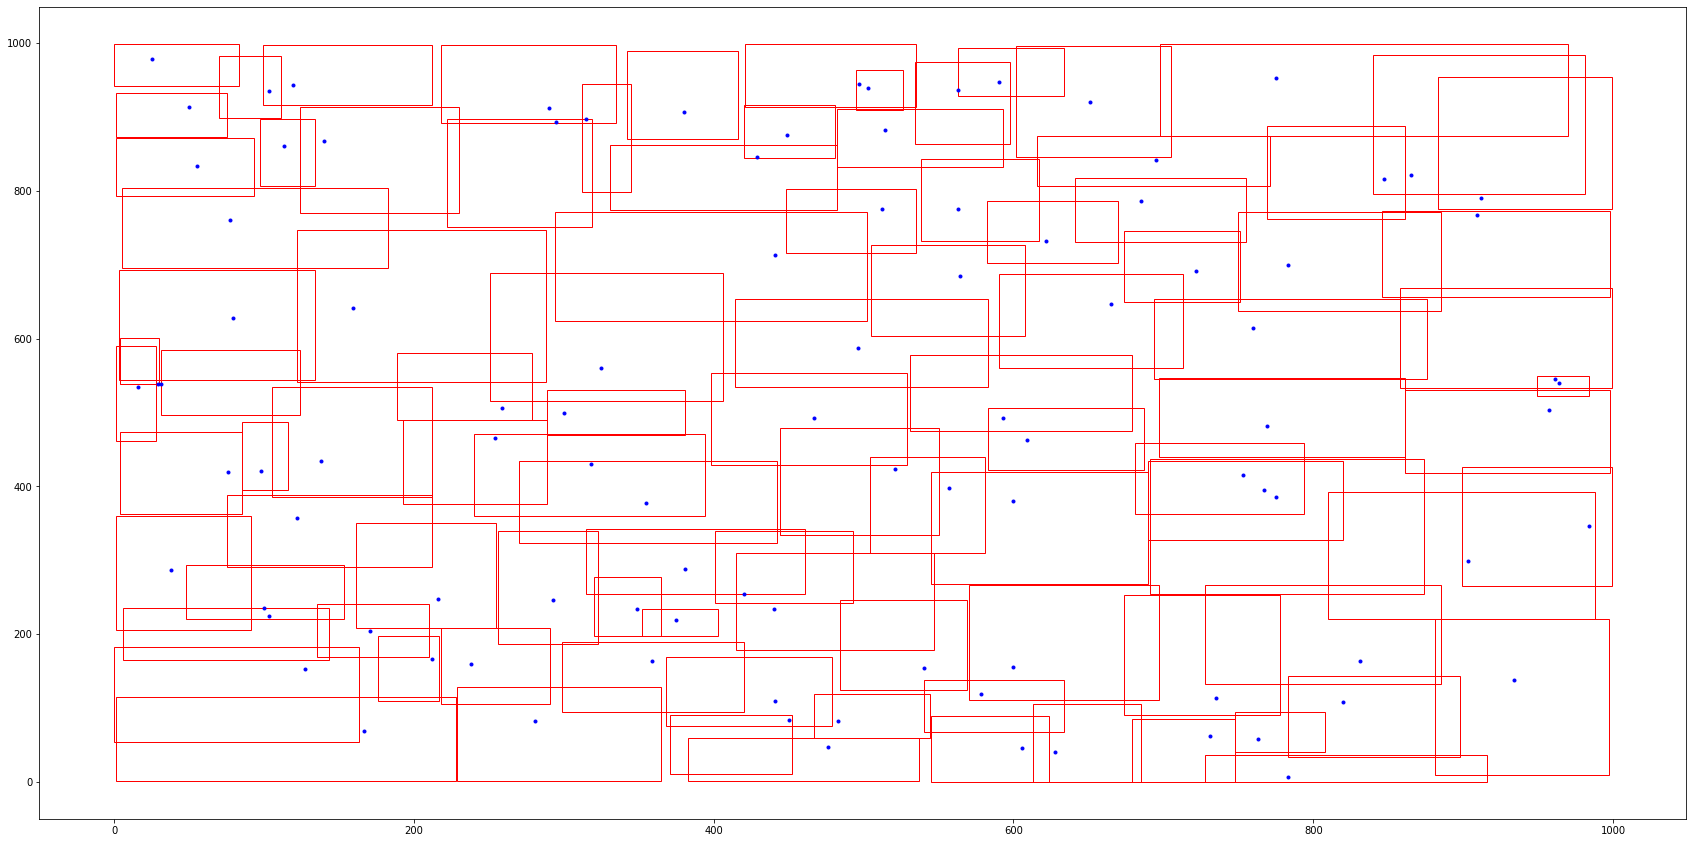

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

for i in range(100):
    clr = 'red'
    min_x = regions[i][1][0]
    min_y = regions[i][1][1]
    max_x = regions[i][1][2]
    max_y = regions[i][1][3]
    rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    cm = 1/2.54
    plt.rcParams["figure.figsize"] = [60*cm, 30*cm]
    alm_x, alm_y = get_coords(regions[i][0])
    plt.plot(alm_x, alm_y, '.', color='blue')
    plt.rcParams["figure.autolayout"] = True
    plt.plot

plt.show()

In [ ]:
def get_my_region(all_regions, member_number):
    regions_size = int(len(all_regions)/5)
    min = member_number*regions_size
    max = (member_number + 1)*regions_size
    member_regions = []
    for i in range(min, max):
        member_regions.append(all_regions[i])

    return member_regions

### **ALGORITMO 1 - Bill Guerrero González - u201821590**

---

In [ ]:
# ALGORITMO 1 - Bill Guerrero González - u201821590

# Not working yet
# def find_route_1(my_regions):
#     routes, regions_adj = all_regions(my_regions)


#     start_node = all_routes[ent_node] #returns parent
#     #ir desde ent_node hasta alm_node con un while, hasta que encuentre el nodo que necesita
#     #Las rutas se obtienen recorriendo las rutas generales de manera inversa
#     route = []
#     route.append(ent_node)

#     if start_node == alm_node: #Comprueba si son nodos adyacentes
#         route.append(alm_node)
#         route.reverse()
#         return route

#     while start_node != alm_node: #Recorre los padres desde el punto de entrega hasta el almacén (inversamente)
#         route.append(start_node)
#         start_node = all_routes[start_node]

#     route.append(alm_node)
#     route.reverse()
#     return route #returns 1 route

def algorithm_1(graph, start):
    visited = {}
    parent = {}
    for i in graph:
        visited[i] = False
        parent[i] = None
    
    visited[start] = True
    queue = [start]

    while queue:
        u = queue.pop(0)
        for v in graph[u]:
            if not visited[v]:
                visited[v] = True
                parent[v] = u
                queue.append(v)

    return parent

def my_routes_1(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_1(nodes, alm)
        routes.append(route)

    return routes


my_regions_1 = get_my_region(regions, 0)
my_regions_routes = my_routes_1(my_regions_1)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{1461: 1462, 1462: 1463, 1463: 1464, 1464: 1465, 1465: 1466, 1466: 1467, 1467: 1468, 1468: 1469, 1469: 1470, 1470: 1471, 1471: 1472, 1472: 1473, 1473: 1474, 1474: 1475, 1475: 1476, 1476: 1477, 1477: 1478, 1478: 1479, 1479: 1480, 1480: 1481, 1481: 1482, 1482: 1483, 1483: 1484, 1484: 1485, 1485: 1486, 1486: 1487, 1487: 1488, 1488: 1489, 1489: 1490, 1490: 1491, 1491: 1492, 1492: 1493, 1493: 1494, 1494: 1495, 1495: 1496, 1496: 1497, 1497: 1498, 1498: 1499, 1499: 1500, 1500: 1501, 1501: 1502, 1502: 1503, 1503: 1504, 1504: 1505, 1505: 1506, 1506: 1507, 1507: 1508, 1508: 1509, 1509: 1510, 1510: 1511, 1511: 1512, 1512: 1513, 1513: 1514, 1514: 1515, 1515: 1516, 1516: 1517, 1517: 1518, 1518: 1519, 1519: 1520, 1520: 1521, 1521: 1522, 1522: 1523, 1523: 1524, 1524: 1525, 1525: 1526, 1526: 1527, 1527: 1528, 1528: 1529, 1529: 1530, 1530: 1531, 1531: 1532, 1532: 1533, 1533: 1534, 1534: 1535, 1535: 2535, 1536: 1535, 1537: 1536, 1538: 1537, 1539: 1538, 1540: 1539, 1541: 1540, 1542: 1541, 1543: 1542, 154

### **ALGORITMO 3 - José Ivan Tarazona Ildefonso - u201823346**

---

In [ ]:
# ALGORITMO 3 - José Ivan Tarazona Ildefonso - u201823346

def algorithm_3(graph, start):
  visited = {}
  path = {}
  cost = {}
  for key in graph.keys():
    visited[key] = False
    path[key] = None
    cost[key] = math.inf

  cost[start] = 0
  queue = [(start, 0)]
  while queue:
    u, g_u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True        
      for v in graph[u]:
        f = g_u + 1
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (v, f))
  return path


def my_routes_3(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = algorithm_3(nodes, alm)
        routes.append(route)

    return routes


my_regions_1 = get_my_region(regions, 2)
my_regions_routes = my_routes_3(my_regions_1)

for i in range(3):
    print(my_regions_routes[i])
print(len(my_regions_routes))

{342870: 342871, 342871: 342872, 342872: 342873, 342873: 342874, 342874: 342875, 342875: 342876, 342876: 342877, 342877: 342878, 342878: 342879, 342879: 342880, 342880: 342881, 342881: 342882, 342882: 342883, 342883: 342884, 342884: 342885, 342885: 342886, 342886: 342887, 342887: 342888, 342888: 342889, 342889: 342890, 342890: 342891, 342891: 342892, 342892: 342893, 342893: 342894, 342894: 342895, 342895: 342896, 342896: 342897, 342897: 342898, 342898: 342899, 342899: 342900, 342900: 342901, 342901: 342902, 342902: 342903, 342903: 342904, 342904: 342905, 342905: 342906, 342906: 342907, 342907: 343907, 342908: 342907, 342909: 342908, 342910: 342909, 342911: 342910, 342912: 342911, 342913: 342912, 342914: 342913, 342915: 342914, 342916: 342915, 342917: 342916, 342918: 342917, 342919: 342918, 342920: 342919, 342921: 342920, 342922: 342921, 342923: 342922, 342924: 342923, 342925: 342924, 342926: 342925, 342927: 342926, 342928: 342927, 342929: 342928, 342930: 342929, 342931: 342930, 342932:

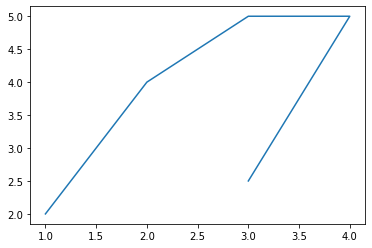

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([[1,2],[2,4],[3,5],[4,5], [3,2.5]])
#plt.plot(data[:, 0], data[:, 1])
plt.plot(*data.T)
plt.show()

### **ALGORITMO 5 - José Adrian Pain Peralta - u201823838**

In [ ]:
#Fibonnaci Heap
def makefheap():
      heap = Fheap()
      return heap
def fheappush(heap, item):
      heap.insert(Node(item))
def getfheapmin(heap):
      return heap.min.key
def fheappop(heap):
      return heap.extract_min().key
def fheapunion(heap, other):
      heap.union(other)

class Node:
    """Methods:
    - add_child: add a child to the node
    - remove_child: remove a child to the node
    """

    def __init__(self, key, p=None, left=None, right=None,
                 child=None, mark = None):
        """Create a new node in a heap. Attributes:
        - key: the node's key, a number
        - left, right: the node's adjacent siblings. The node and its siblings
        are doubly linked, so they form a circular loop. If x is an only child,
        it is its own left and right sibling.
        - child: the representative child of the node. To access all the
        children of the node, first access the representative child through
        self.child, then access all the child's siblings through self.left or
        self.right.
        - p: the node's parent
        - degree: the number of the node's children whether the node has lost a
        child since the last time it was made the child of another node. Newly
        created nodes are unmarked. A node becomes unmarked whenever it is made
        the child of another node.
        """
        self.key = key
        self.left = left
        self.right = right
        self.p = p # parent
        self.child = child # to any one of its children
        self.degree = 0
        self.mark = False if not mark else mark

    def add_child(self, x):
        """Add a child to the node. If the node currently has no children, the
        child is made the representative child, otherwise, it is added to the
        right of the representative child.
        This procedure updates the child's parent and mark,
        and the node's degree.
        """
        if not self.child:
            self.child = x
            x.left, x.right = x, x
        else:
            right_to_child = self.child.right
            self.child.right = x
            x.left = self.child
            x.right = right_to_child
            right_to_child.left = x
        x.p = self
        self.degree += 1
        x.mark = False

    def remove_child(self, x):
        """ remove a child from the node's child list. This procedure does not
        update the child's parent and does not allow removing a child that does
        not exist. Updating the child's parent is the reponsibility of routines
        that call this function.
        """
        if not self.child:
            raise ValueError('Child list is currently empty')
        if self.degree == 1: # has 1 child
            self.child = None
        else: # >= 2 children
            if self.child is x:
                self.child = x.right
            left_to_x, right_to_x = x.left, x.right
            left_to_x.right = right_to_x
            right_to_x.left = left_to_x
        self.degree -= 1
        
class Fheap:
    """ Methods: insert, minimum, extract_min, union, decrease_key, delete"""

    def __init__(self, minimum=None):
        """Create a new, empty heap. Attributes:
        - min: points to the node that contains the minimum key
        - num_nodes: number of nodes currently in the heap
        - num_trees: number of roots in the tree A Fibonacci heap can contain
        many trees of min-ordered heap. The roots of these trees are doubly
        linked and form a circular loop as in the case with siblings. The number
        of trees of a Fibonacci heap is always the number of roots.
        - num_marks: number of marked nodes in the heap
        """
        self.min = minimum
        self.num_nodes = 0
        self.num_trees = 0
        self.num_marks = 0

    def remove_root(self,x):
        """ Remove a root from the list of roots of the heap.
        This only updates the pointers of the remaining roots and the number of
        trees of the heap, but does not update the pointers of the removed root
        or those of its children. Those are the responsibility of the routines
        that call this function
        """
        right_to_x, left_to_x = x.right, x.left
        right_to_x.left = left_to_x
        left_to_x.right = right_to_x
        self.num_trees -= 1

    def add_root(self, x):
        """Add a root to the list of roots of the heap.
        If the heap is currently empty, the added root is the min of the heap
        and is its own left and right roots.
        """
        if self.min == None:
            x.left, x.right = x, x
        else:
            right_to_min = self.min.right
            self.min.right = x
            x.left = self.min
            x.right = right_to_min
            right_to_min.left = x
        self.num_trees += 1

    def insert(self, x):
        """Add a node.
        This simply adds the node as a root of the heap, updates the minimum
        node of the heap if necessary, and updates the number of nodes. For example,
        - Before insertion, one root ((2)), minimum = (2):
                (2)
               /   \
              (3)  (4)
        - After inserting (1), two roots ((1) and (2)), minimum = (1):
                (2)---(1)
               /   \
              (3)  (4)
        """
        if self.min == None:
            self.add_root(x)
            self.min = x
        else:
            self.add_root(x)
            if x.key < self.min.key:
                self.min = x
        self.num_nodes += 1

    def minimum(self):
        """Return the node with the minimum key"""
        return self.min

    def extract_min(self):
        """Remove and return the minimum nodeself.
        This procecures moves each of the minimum node's children to the root
        list, removes the minimum node itself from the root list, and
        "consolidate" (see consolidate) the resulted tree.
        """
        z = self.min
        if z != None:
            x = z.child
            for i in range(z.degree):
                y = x.right
                self.add_root(x)
                x.p = None
                x = y
            if z.mark:
                self.num_marks -= 1
            self.remove_root(z)
            if z == z.right:
                self.min = None
            else:
                self.min = z.right
                self.consolidate()
            self.num_nodes -= 1
        return z

    def consolidate(self):
        """ The goal is to reduce the number of trees in the current heap.
        The procedure is as follows (description by Corment et al.):
        1. Find two roots that have the same degree (the same number of
        children)
        2. Merge the two trees rooted at those two roots by making the root with
        larger key one child of the one with smaller key. This procedure is
        called link (see the documentation for link)
        3. Repeat step 1 and 2 until no two roots in the tree have the same degree
        For example,
        - Before consolidating: 3 roots ((1),(4), and (5)), root (1) and (4)
        have the same degree of 1
            (1)---(4)---(5)
             |     |
            (3)   (6)
        - After consolidating: 2 roots ((1) and (5)), root (1) has degree 2
        while root (5) has degree 0.
            (1)---(5)
           /   \
          (3)  (4)
                |
               (6)
        """
        A = [None] * self.num_nodes
        root = self.min
        counter = self.num_trees
        while counter:
            x = root
            root = root.right
            d = x.degree
            while A[d]:
                y = A[d]
                if x.key > y.key:
                    x,y = y,x
                self.link(y, x)
                A[d] = None
                d += 1
            A[d] = x
            counter -= 1
        self.min = None
        for i in range(len(A)):
            if A[i]:
                if self.min == None:
                    self.min = A[i]
                else:
                    if A[i].key < self.min.key:
                        self.min = A[i]

    def link(self, y, x): # y>x
        """Link y to x.
        This procesure makes y a child of x. Because when a node becomes a child
        of another, it has no mark, so the number of marks of the heap is
        updated if necessary.
        """
        self.remove_root(y)
        if y.mark == True:
            self.num_marks -= 1
        x.add_child(y)

    def union(self, other):
        """Make a union of two heaps. This procedure simply concatenates the two
        root lists and updates the minimum node, the number of nodes, the number
        trees, and the number of marks of the heap.
        """
        if not self.min:
            self.min = other.min
        elif other.min:
            self_first_root, other_last_root = self.min.right, other.min.left
            self_first_root.left = other_last_root
            self.min.right = other.min
            other.min.left = self.min
            other_last_root.right = self_first_root

        if (self.min == None) or (other.min != None and other.min.key < self.min.key):
            self.min = other.min
        self.num_nodes += other.num_nodes
        self.num_trees += other.num_trees
        self.num_marks += other.num_marks

    def decrease_key(self, x, k):
        """Decrease node x's key to k.
        k must be larger than the current key of x. If by decreasing x's key to
        k, the heap invariant is violated, x (and therefore along with its
        children) will be cut from its current tree and added to the root list
        (see the function cut). The parent y of x may have had lost one of its
        child before. If this is the case and if y is not a root, then y is, in
        turn, cut from its parent. The nodes are continually cut using
        cascading_cut until it "finds either a root or an unmark node" (Cormen
        et al.).
        """
        if k > x.key:
            raise ValueError('new key is greater than current key')
        x.key = k
        y = x.p
        if y and x.key < y.key:
            self.cut(x, y)
            self.cascading_cut(y)
        if x.key < self.min.key:
            self.min = x

    def cut(self, x, y):
        """ Cut x from y and make it a root.
        x's parent is set to None and x's mark and the heap's number of marks
        are updated if necessary.
        """
        if x.mark:
            self.num_marks -= 1
            x.mark = False
        y.remove_child(x)
        self.add_root(x)
        x.p = None

    def cascading_cut(self, y):
        """Cut continually until it finds either a root or an unmarked node."""
        z = y.p
        if z:
            if not y.mark:
                y.mark = True
                self.num_marks += 1
            else:
                self.cut(y, z)
                self.cascading_cut(z)

    def delete(self, x):
        """Remove x from the heap by first setting its key to minus infinity and
        extracting the heap's min.
        """
        class MaskClass:
            def __lt__(self, other):
                return True

            def __gt__(self, other):
                return False

        mask_key = MaskClass() # the key is smaller than any other keys
        self.decrease_key(x, mask_key)
        self.extract_min()

In [ ]:
#Dijkstra with fibonnaci heap

def dijkstraFibonnaci(graph, start):
    fheap1 = {}
    visited = {}
    parent = {}
    cost = {}
    fheap1[start] = 0
    for i in graph.keys():
        visited[i] = False
        parent[i] = None
        cost[i] = math.inf
    
    cost[start] = 0
    while fheap1:
        u, g_u = heappop(fheap1)
        if not visited[u]:
            visited[u] = True
            for v in graph[u]:
                f = g_u + 1 #No cost
                if f < cost[v]:
                    cost[v] = f
                    parent[v] = u
                    heapush(fheap1,(v, f))

    return parent

def my_routes_4(my_regions):
    routes = []

    for i in range(len(my_regions)):
        alm, region = my_regions[i]
        nodes = adjacencies(region)

        route = new_dijkstra(nodes, alm)
        routes.append(route)

    return routes


my_regions_4 = get_my_region(regions, 4)
my_regions_routes = my_routes_4(my_regions_4)

for i in range(20):
    print(my_regions_routes[i])
print(len(my_regions_routes))